In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [25]:
import dspy

GROQ_TOKEN = Path("../groq_token.txt").read_text().strip()
os.environ["GROQ_API_KEY"] = GROQ_TOKEN

# lm = dspy.LM('groq/llama-3.3-70b-versatile')
lm = dspy.LM('groq/llama-3.1-8b-instant')
dspy.configure(lm=lm)

INPUT_DIR: str = "../available_apis/"

### Task description: Classify Quantum Circuit APIs

**Objective:**
Create a Python script to classify API calls based on their `api_signature` and `api_description` fields from a JSON file. The classification should determine if the API call takes a quantum circuit and returns a semantically equivalent circuit using the `dspy` classifier.

**Requirements:**
1. Parse the JSON file to extract API details.
2. Use the `dspy` classifier to classify each API call.
3. Add a new field `likely_circuit_transformation` with values `likely_yes`, `likely_no`, or `unsure` to each API object.
4. Save the modified JSON file in the same directory as the input file.

**Steps:**
1. Read the JSON file located at 

qiskit.json

.
2. Extract relevant fields (`api_signature` and `api_description`).
3. Configure the `dspy` classifier.
4. Classify each API call.
5. Add the `likely_circuit_transformation` field to each API object.
6. Save the modified JSON file.

**Example JSON Object:**


```json
{
    "api_name": "short_path",
    "full_api_name": "short_path",
    "api_description": "shorten the full path, when possible",
    "api_signature": "short_path(path)",
    "file_path": "platform_repos/qiskit/tools/find_deprecated.py"
}
```



**Example `dspy` Usage:**


```python
import dspy
from pathlib import Path
import os

# Read the groq token
GROQ_TOKEN = Path("../groq_token.txt").read_text().strip()
os.environ["GROQ_API_KEY"] = GROQ_TOKEN

lm = dspy.LM('groq/llama-3.3-70b-versatile')
dspy.configure(lm=lm)

class Categorize(dspy.Signature):
    """Classify historic events."""

    event: str = dspy.InputField()
    category: Literal[
        "Wars and Conflicts",
        "Politics and Governance",
        "Science and Innovation",
        "Cultural and Artistic Movements",
        "Exploration and Discovery",
        "Economic Events",
        "Social Movements",
        "Man-Made Disasters and Accidents",
        "Natural Disasters and Climate",
        "Sports and Entertainment",
        "Famous Personalities and Achievements"
    ] = dspy.OutputField()
    confidence: float = dspy.OutputField()

classify = dspy.Predict(Categorize)

# Here is how we call this module
classification = classify(event="[YOUR HISTORIC EVENT]")
```

In [27]:
from typing import Literal
import time

MAX_APIS_TO_PROCESS: int = 130

# Step 1: Read the JSON file located at qiskit.json
input_file = os.path.join(INPUT_DIR, 'qiskit.json')
with open(input_file, 'r') as file:
    api_data = json.load(file)

n_apis = len(api_data)
print(f"Number of APIs: {n_apis}")

# keep only those with api_description not empty string
api_data = [api for api in api_data if api['api_description'] != '']
n_apis = len(api_data)
print(f"Number of APIs with non-empty descriptions: {n_apis}")

# Step 2: Extract relevant fields (api_signature, api_description, and full_api_name)
api_details = [(api['api_signature'], api['api_description'],
                api['full_api_name']) for api in api_data]

# Step 3: Configure the dspy classifier


class CircuitTransformation(dspy.Signature):
    """Classify API calls for quantum circuit transformation.

    Determine whether a given API call is likely to take a quantum circuit as
    input and return a quantum circuit as output.
    """

    api_signature: str = dspy.InputField()
    api_description: str = dspy.InputField()
    full_api_name: str = dspy.InputField()
    likely_circuit_transformation: Literal[
        "likely_yes",
        "likely_no",
        "unsure"
    ] = dspy.OutputField()


classify_circuit = dspy.Predict(CircuitTransformation)


def retry_if_exception(func, delay_in_seconds: int = 1, max_attempts: int = 5):
    def wrapper(*args, **kwargs):
        delay = delay_in_seconds
        attempts = 0
        while attempts < max_attempts:
            try:
                return func(*args, **kwargs)
            except Exception as e:
                attempts += 1
                print(f"Exception: {e}")
                if attempts < max_attempts:
                    print(f"Retrying in {delay} seconds...")
                    time.sleep(delay)
                    delay *= 2
                else:
                    raise e

    return wrapper


# Step 4: Classify each API call
for i, api in enumerate(
    tqdm(
        api_data[: MAX_APIS_TO_PROCESS],
        desc="Classifying APIs")):
    classification = retry_if_exception(classify_circuit)(
        api_signature=api['api_signature'],
        api_description=api['api_description'],
        full_api_name=api['full_api_name']
    )
    time.sleep(1)
    # Step 5: Add the likely_circuit_transformation field to each API object
    api['likely_circuit_transformation'] = classification.likely_circuit_transformation

# Step 6: Save the modified JSON file
output_file = os.path.join(INPUT_DIR, 'qiskit_modified.json')
with open(output_file, 'w') as file:
    json.dump(api_data, file, indent=4)

Number of APIs: 14324
Number of APIs with non-empty descriptions: 10886


Classifying APIs:   0%|          | 0/130 [00:00<?, ?it/s]

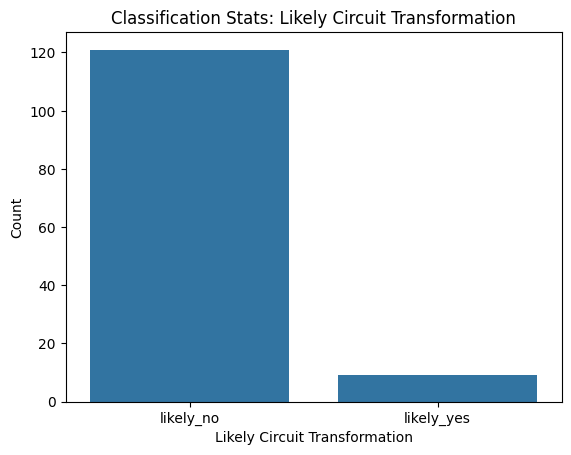

In [28]:
# Extract the likely_circuit_transformation values
transformation_stats = [
    api['likely_circuit_transformation']
    for api in api_data[: MAX_APIS_TO_PROCESS]]

# Create a count plot using seaborn
sns.countplot(x=transformation_stats)
plt.title('Classification Stats: Likely Circuit Transformation')
plt.xlabel('Likely Circuit Transformation')
plt.ylabel('Count')
plt.show()

In [29]:
TO_PRINT = 15
likely_yes_apis = [
    api for api in api_data[: MAX_APIS_TO_PROCESS]
    if api['likely_circuit_transformation'] == 'likely_yes']

for api in likely_yes_apis[:TO_PRINT]:
    print("-" * 80)
    print(f"Full API Name: {api['full_api_name']}")
    print(f"API Signature: {api['api_signature']}")
    print(f"File path: {api['file_path']}")
    print("-" * 80)
    print(f"{api['api_description']}")
    print("=" * 80)

--------------------------------------------------------------------------------
Full API Name: majority
API Signature: majority(p, a, b, c)
File path: platform_repos/qiskit/examples/python/rippleadd.py
--------------------------------------------------------------------------------
Majority gate.
--------------------------------------------------------------------------------
Full API Name: unmajority
API Signature: unmajority(p, a, b, c)
File path: platform_repos/qiskit/examples/python/rippleadd.py
--------------------------------------------------------------------------------
Unmajority gate.
--------------------------------------------------------------------------------
Full API Name: input_state
API Signature: input_state(circ, n)
File path: platform_repos/qiskit/examples/python/qft.py
--------------------------------------------------------------------------------
n-qubit input state for QFT that produces output 1.
---------------------------------------------------------------